Initially we'll import libraries, and load some data that's already been a bit pre-processed. Particularly, categorical variables have been binarized.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from logisticSmoothing import smoothedLookupEstimator
from sklearn.preprocessing import Imputer
from outcomeVariables import getOutcomeVariable

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

There are a few different variables in this dataset that include readmission data. READMISSION is depricated, but still has data for older records. READMISSION1 is the current variable. It makes sense to try to merge these to be our regression target. No records have data for both. Of the 19533 records, 4537 don't have readmission data recorded either way, so we'll discard those.

In [2]:
# y is True for bad things happening.
# 'readmission', 'reoperation', 'morbidity', 'mortality', 'infection'
from outcomeVariables import getOutcomeVariable
yFull = getOutcomeVariable(cdf, 'morbidity')

In [3]:
# Drop rows with NaN outcome y data
nanIdx = np.isnan(yFull).nonzero()
yFull = np.delete(yFull.ravel(), nanIdx ,axis=0).reshape(-1,1)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

It makes sense to add a BMI column, calculated from patient height and weight.

In [4]:
# Add a BMI column
cdf.loc[:,'BMI'] = cdf.loc[:,'WEIGHT']*(1/2.20462)/(cdf.loc[:,'HEIGHT']*(1/39.3701)*\
                                                    cdf.loc[:,'HEIGHT']*(1/39.3701))

This dataset has many predictors in it that document post-procedure occurrences. These may be interesting, but they're not useful as predictors. So, we'll only select interesting potential predictors from the list below. Note that the binarization procedure decorates the column names of categorical predictors with the names of each column, so we're just trying to match the start of the name.

You guys provided me with a list of predictors you wanted to study, which I translated as `keepList1`. I added a few more in `keepList2`.

In [5]:
# List of predictors to keep
keepList1 = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','BMI',\
             'DIABETES','SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT',\
             'HXCOPD','CPNEUMON','HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED',\
             'HXPVD','RENAFAIL','DIALYSIS','CVA','DISCANCR','WNDINF-','STEROID','WTLOSS',\
             'BLEEDDIS','PROPER30','ASACLASS','FNSTATUS1','RBC']
# An additional list of predictors that might be interesting
keepList2 = ['ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH',\
             'PRWBC','PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY','ESOVAR','RESTPAIN',\
             'HXTIA','TRANSFUS','CHEMO','RADIO','PRSEPSIS','PREGNANCY','EMERGNCY',\
             'OPTIME','MALLAMP']

# Combine the lists
keepList = keepList1 + keepList2
# Make a list of any column in cdf whose name starts with a string in keepList
colsToKeep = [colName for colName in cdf.columns \
              if np.any([colName.startswith(keepItem) for keepItem in keepList])]
cdf = cdf[colsToKeep]

For each variable in this list, we'll look at its association with the target variable we want to predict (eg. readmission) in a few ways. Since we only care about one predictor at a time, we'll drop any cases for which the predictor data is missing. Note that for some predictors and some outcomes, if we drop all the null outcomes we may not have any variance left in the predictors. (For example, if we drop cases with no readmission data, only cases that received 0 units of RBCs are left.)

In each case we'll assess how well the model does using cross validation. That is, we'll split the data into 10 parts, fit the model with 9 of them, and measure the performance with the held-out part. We do this ten times, and then average the performance across the 10 replicates.

As a measure of performance, we'll look at the receiver-operator characteristic curve (ROC), and calculate the area under the curve (ROC AUC). The ROC allows quantification of the performance of a binary classifier over varying discrimination thresholds. (Changing the discrimination threshold allows the user to trade false-positives for false-negatives.) The ROC AUC is 0.5 at chance, and 1.0 for perfect performance. For a brief introduction to the ROC curve, see [Wikipedia](https://en.m.wikipedia.org/wiki/Receiver_operating_characteristic). For a more comprehensive introduction, see: 

Green, D. M., & Swets, J. A. (1966). Signal detection theory and psychophysics. 1966. New York, 888, 889.

We'll look at 3 types of classifiers:

(1) For categorical predictors (eg. SEX, SMOKE, etc.) we'll just make a simple category classifier. In addition to the out-of-sample cross validation performance, we will also give a p-value for this based on a $\chi^2$ test.

(2) For ordinal and continuous predictors (Eg. AGE, BMI, PACKS, etc.) we'll do a logistic regression, fitting a logit transformed linear model to the probability of the predictor. This model will fit and predict well when admission odds are linear with the predictor. This functional relationship isn't really the case very often with this data, although the linear predictions do fine.

(3) For ordinal and continuous predictors we'll also construct a look-up table from a gaussian smoothed average. We'll use cross-validation to find the smoothing parameter that allows optimal predictions. This model (and bootstrapped confidence intervals) can be plotted to allow us to get a sense of whether there's a non-linear functional relationship between the predictors and response probability. This model will disregard the tails of the predictor distribution, because they tend to be dominated by poorly sampled outliers.

--- C AGE: Continuous Predictor ---
	 Mean linear score: 0.673
	 Mean lookup score: 0.673
	 Bootstrapping confidence intervals...


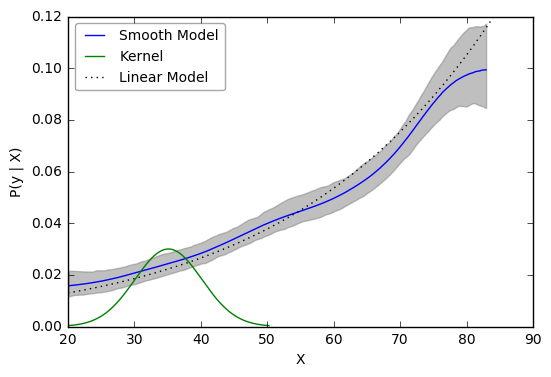

---   ANESTHES-Epidural: Binary Predictor ---
	 Mean linear score: 0.501
---   ANESTHES-General: Binary Predictor ---
	 Mean linear score: 0.516
---   ANESTHES-Local: Binary Predictor ---
	 Mean linear score: 0.500
---   ANESTHES-MAC/IV Sedation: Binary Predictor ---
	 Mean linear score: 0.508
---   ANESTHES-Monitored Anesthesia Care: Binary Predictor ---
	 Mean linear score: 0.500
---   ANESTHES-None: Binary Predictor ---
	 Mean linear score: 0.500
---   ANESTHES-Other: Binary Predictor ---
	 Mean linear score: 0.499
---   ANESTHES-Regional: Binary Predictor ---
	 Mean linear score: 0.505
---   ANESTHES-Spinal: Binary Predictor ---
	 Mean linear score: 0.502
---   ANESTHES_OTHER-Epidural: Binary Predictor ---
	 Mean linear score: 0.492
---   ANESTHES_OTHER-Epidural,Regional: Binary Predictor ---
	 Mean linear score: 0.500
---   ANESTHES_OTHER-General: Binary Predictor ---
	 Mean linear score: 0.486
---   ANESTHES_OTHER-Local: Binary Predictor ---
	 Mean linear score: 0.526
---   ANEST

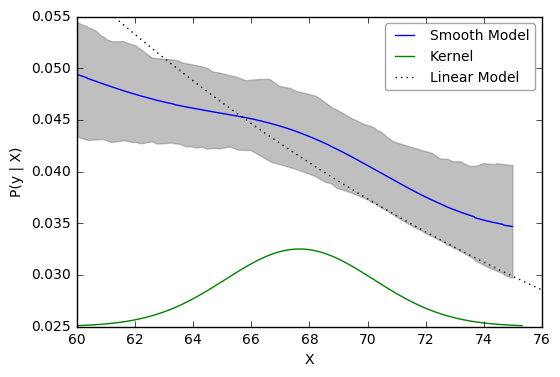

---   HXANGINA-Yes: Binary Predictor ---
	 Mean linear score: 0.502
---   HXCHF-Yes: Binary Predictor ---
	 Mean linear score: 0.507
---   HXCOPD-Yes: Binary Predictor ---
	 Mean linear score: 0.526
---   HXMI-Yes: Binary Predictor ---
	 Mean linear score: 0.510
---   HXPVD-Yes: Binary Predictor ---
	 Mean linear score: 0.535
---   HXTIA-Yes: Binary Predictor ---
	 Mean linear score: 0.506
---   HYPERMED-Yes: Binary Predictor ---
	 Mean linear score: 0.634
---   MALLAMP-1.0: Binary Predictor ---
	 Mean linear score: 0.538
---   MALLAMP-2.0: Binary Predictor ---
	 Mean linear score: 0.527
---   MALLAMP-3.0: Binary Predictor ---
	 Mean linear score: 0.517
---   MALLAMP-4.0: Binary Predictor ---
	 Mean linear score: 0.506
--- C OPTIME: Continuous Predictor ---
	 Mean linear score: 0.553
	 Mean lookup score: 0.553
	 Bootstrapping confidence intervals...


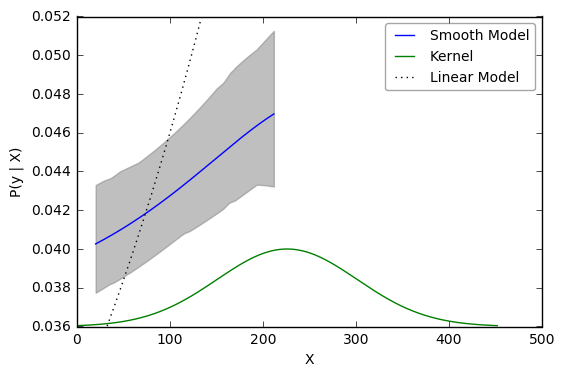

--- C PACKS: Continuous Predictor ---
	 Mean linear score: 0.521
	 Mean lookup score: 0.526
	 Bootstrapping confidence intervals...


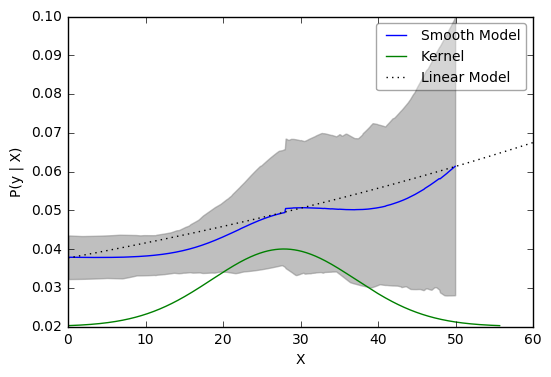

--- C PGY: Continuous Predictor ---
	 Mean linear score: 0.483
	 Mean lookup score: 0.511
	 Bootstrapping confidence intervals...


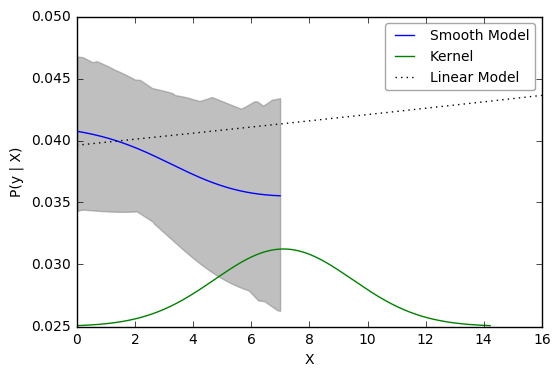

--- C PRALBUM: Continuous Predictor ---
	 Mean linear score: 0.691
	 Mean lookup score: 0.691
	 Bootstrapping confidence intervals...


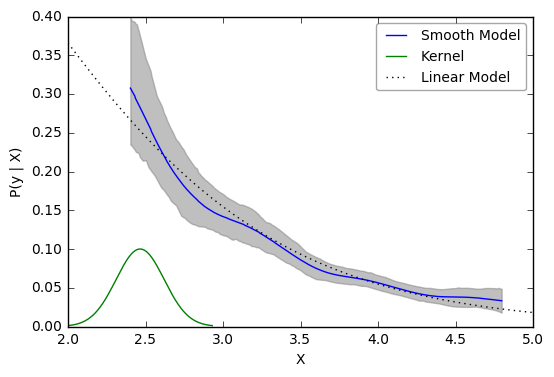

--- C PRALKPH: Continuous Predictor ---
	 Mean linear score: 0.588
	 Mean lookup score: 0.588
	 Bootstrapping confidence intervals...


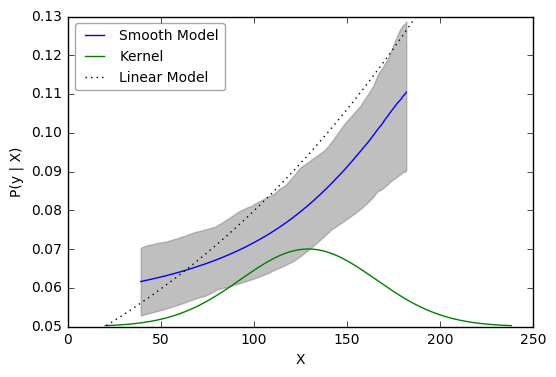

--- C PRBILI: Continuous Predictor ---
	 Mean linear score: 0.530
	 Mean lookup score: 0.530
	 Bootstrapping confidence intervals...


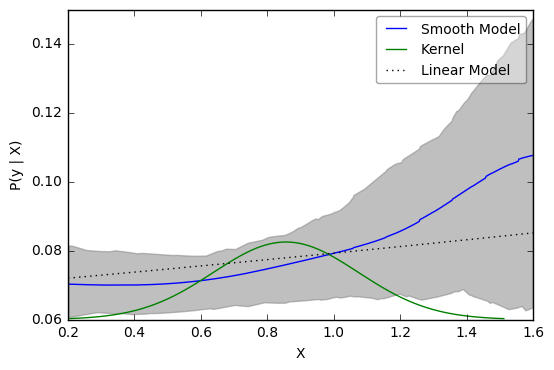

--- C PRBUN: Continuous Predictor ---
	 Mean linear score: 0.610
	 Mean lookup score: 0.615
	 Bootstrapping confidence intervals...


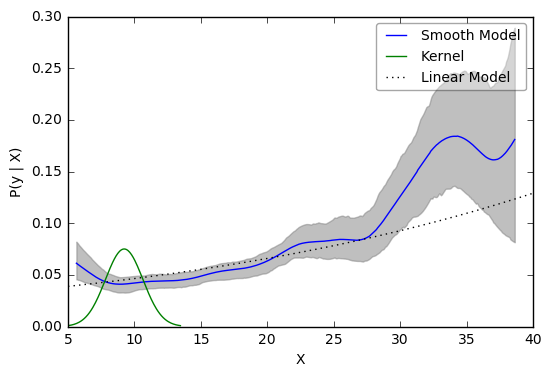

--- C PRCREAT: Continuous Predictor ---
	 Mean linear score: 0.597
	 Mean lookup score: 0.598
	 Bootstrapping confidence intervals...


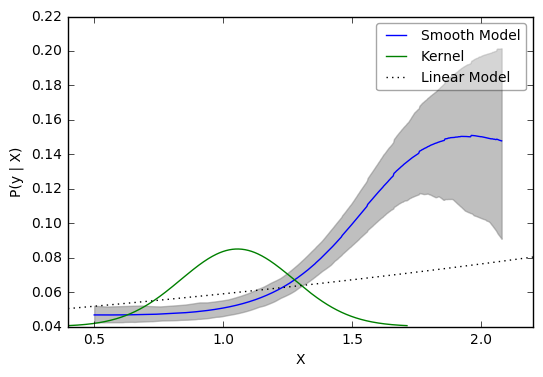

---   PREGNANCY-Yes: Binary Predictor ---
	 Mean linear score: 0.501
--- C PRHCT: Continuous Predictor ---
	 Mean linear score: 0.698
	 Mean lookup score: 0.697
	 Bootstrapping confidence intervals...


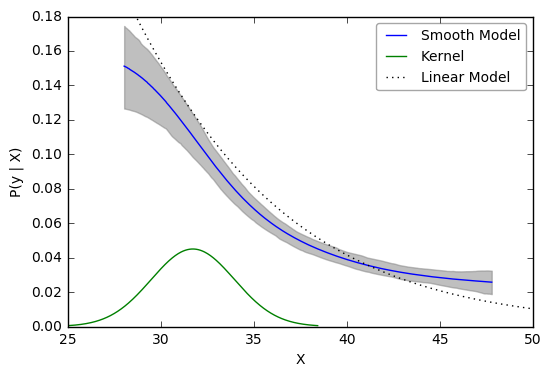

--- C PRINR: Continuous Predictor ---
	 Mean linear score: 0.620
	 Mean lookup score: 0.619
	 Bootstrapping confidence intervals...


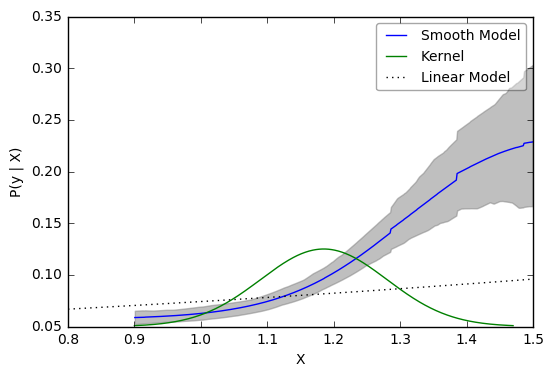

---   PROPER30-Yes: Binary Predictor ---
	 Mean linear score: 0.520
--- C PRPLATE: Continuous Predictor ---
	 Mean linear score: 0.552
	 Mean lookup score: 0.567
	 Bootstrapping confidence intervals...


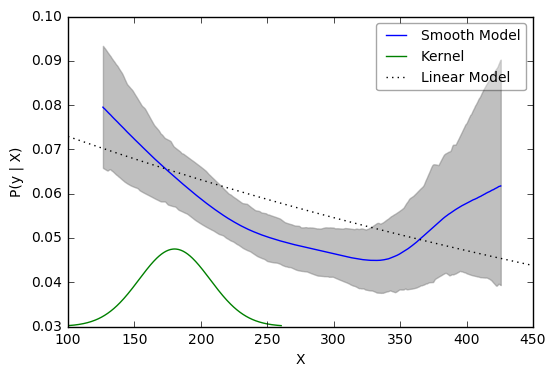

--- C PRPT: Continuous Predictor ---
	 Mean linear score: 0.560
	 Mean lookup score: 0.571
	 Bootstrapping confidence intervals...


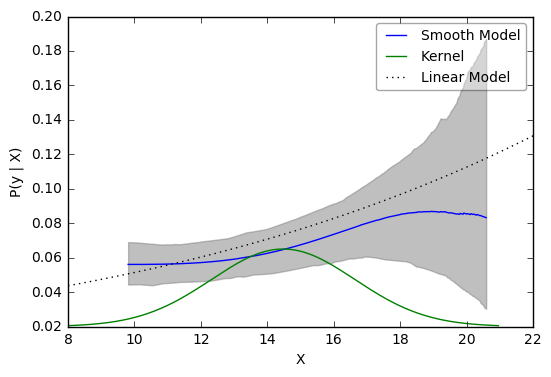

--- C PRPTT: Continuous Predictor ---
	 Mean linear score: 0.575
	 Mean lookup score: 0.585
	 Bootstrapping confidence intervals...


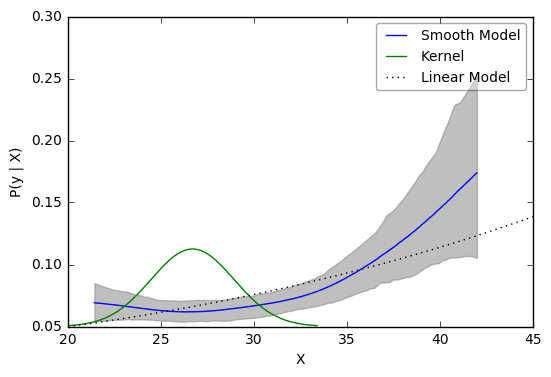

--- C PRSGOT: Continuous Predictor ---
	 Mean linear score: 0.486
	 Mean lookup score: 0.539
	 Bootstrapping confidence intervals...


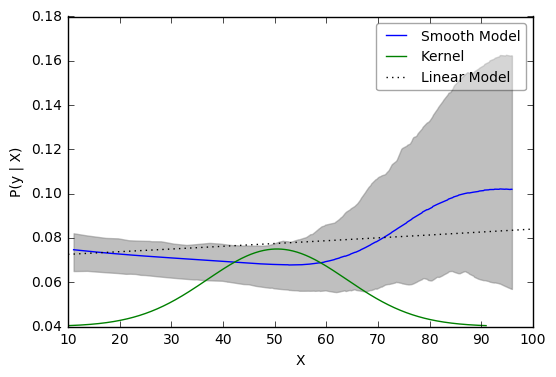

--- C PRSODM: Continuous Predictor ---
	 Mean linear score: 0.560
	 Mean lookup score: 0.572
	 Bootstrapping confidence intervals...


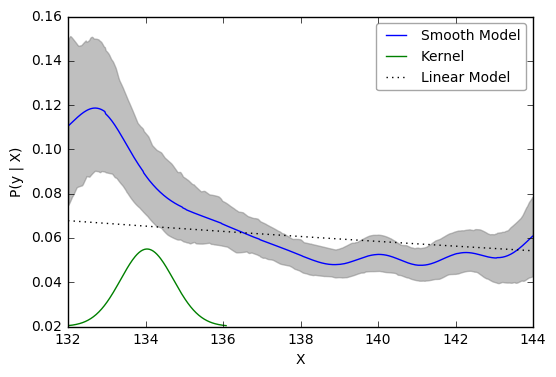

---   PRVPCI-Yes: Binary Predictor ---
	 Mean linear score: 0.532
---   PRVPCS-Yes: Binary Predictor ---
	 Mean linear score: 0.526
--- C PRWBC: Continuous Predictor ---
	 Mean linear score: 0.546
	 Mean lookup score: 0.545
	 Bootstrapping confidence intervals...


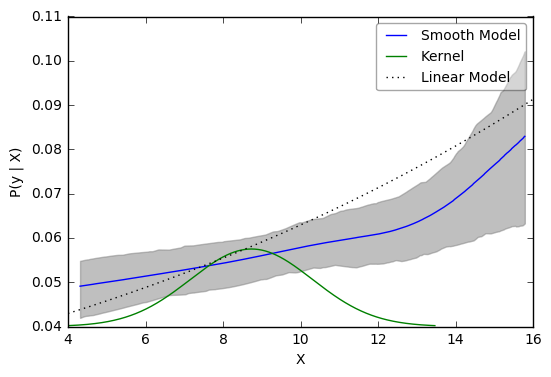

---   RACE_NEW-American Indian or Alaska Native: Binary Predictor ---
	 Mean linear score: 0.502
---   RACE_NEW-Asian: Binary Predictor ---
	 Mean linear score: 0.502
---   RACE_NEW-Black or African American: Binary Predictor ---
	 Mean linear score: 0.503
---   RACE_NEW-Native Hawaiian or Pacific Islander: Binary Predictor ---
	 Mean linear score: 0.499
---   RACE_NEW-Unknown: Binary Predictor ---
	 Mean linear score: 0.488
---   RACE_NEW-Unknown/Not Reported: Binary Predictor ---
	 Mean linear score: 0.510
---   RACE_NEW-White: Binary Predictor ---
	 Mean linear score: 0.512
---   RADIO-Yes: Binary Predictor ---
	 Mean linear score: 0.500
--- C RBC: Continuous Predictor ---
	 Mean linear score: 0.492
*** Bin Edge Calculations in logisticSmoothing.py Failed ***
*** Bin Edge Calculations in logisticSmoothing.py Failed ***
*** Bin Edge Calculations in logisticSmoothing.py Failed ***
*** Bin Edge Calculations in logisticSmoothing.py Failed ***
*** Bin Edge Calculations in logisticSmoothi

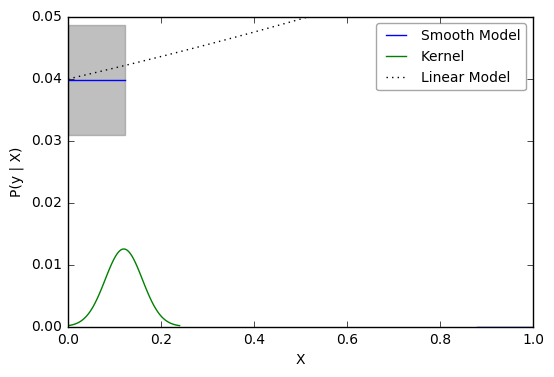

---   RENAFAIL-Yes: Binary Predictor ---
	 Mean linear score: 0.510
---   RESTPAIN-Yes: Binary Predictor ---
	 Mean linear score: 0.528
---   SEX-female: Binary Predictor ---
	 Mean linear score: 0.535
---   SEX-male: Binary Predictor ---
	 Mean linear score: 0.535
---   SMOKE-Yes: Binary Predictor ---
	 Mean linear score: 0.492
---   STEROID-Yes: Binary Predictor ---
	 Mean linear score: 0.514
---   TRANSFUS-Yes: Binary Predictor ---
	 Mean linear score: 0.516
---   VENTILAT-Yes: Binary Predictor ---
	 Mean linear score: 0.507
--- C WEIGHT: Continuous Predictor ---
	 Mean linear score: 0.534
	 Mean lookup score: 0.535
	 Bootstrapping confidence intervals...


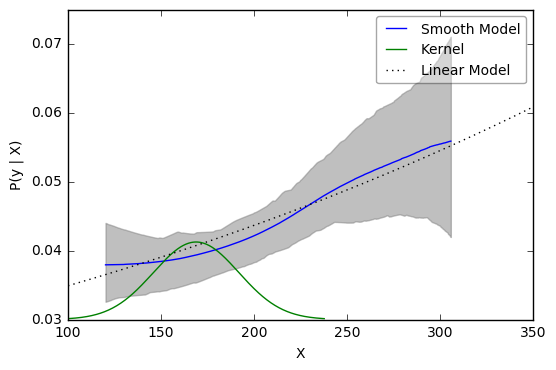

---   WNDINF-Yes: Binary Predictor ---
	 Mean linear score: 0.578
---   WTLOSS-Yes: Binary Predictor ---
	 Mean linear score: 0.498
--- C BMI: Continuous Predictor ---
	 Mean linear score: 0.563
	 Mean lookup score: 0.567
	 Bootstrapping confidence intervals...


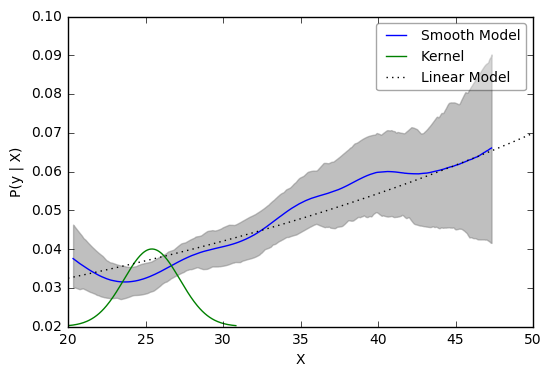

In [6]:

# For each predictor column...
for colName in cdf.columns:
    
    # Select a column as a predictor
    X = np.asarray(cdf[colName]).reshape(-1,1)
    
    # Remove missing values from both 
    y = yFull[~np.isnan(X.astype('float'))].astype(float)
    X = X[~np.isnan(X.astype('float'))].reshape(-1,1).astype(float)
    
  
    # If there are more than two values in X, we're continuous
    if len(np.unique(X)) > 2:
        print('--- C %s: Continuous Predictor ---' % colName)

        # Fit a LR model
        lr = lm.LogisticRegression(fit_intercept=True, penalty='l2', C=1000)
        scores = cross_val_score(lr, X, y, cv=10, scoring='roc_auc')
        lr.fit(X,y)
        print('\t Mean linear score: %.3f' % scores.mean())
        
        # Fit a smoothed lookup estimator
        sle = smoothedLookupEstimator(nBins=512)
        Xrange = np.abs(X.max() - X.min())
        # Search for the best smoothing parameter
        tuned_parameters = [{'sigma': Xrange*np.logspace(-2,-.5,10,base=10)}]
        gscv = GridSearchCV(sle,tuned_parameters,cv=10,verbose=0)
        gscv.fit(X, y)
        print('\t Mean lookup score: %.3f' % gscv.best_score_)
        # Plot the best estimator with confidence intervals
        sle = gscv.best_estimator_
        sle.bootModelCI(X,y,200,0.05)
        plt.figure()
        sle.plotModel(plt.gca(), label='Smooth Model')

        # Plot the LR model on the plot
        plt.gca().set_autoscalex_on(False)
        plt.gca().set_autoscaley_on(False)
        xlims = plt.gca().get_xlim()
        xlr = np.linspace(xlims[0],xlims[1],256)
        ylr = lr.predict_proba(xlr.reshape(-1,1))
        plt.plot(xlr,ylr[:,1],color='k',ls=':',label='Linear Model')
        plt.gca().legend(loc='best', fancybox=True, framealpha=0.35, fontsize=10)
        plt.show()
        
    else:
        
        print('---   %s: Binary Predictor ---' % colName)
        
        if (sum(y == 0) < 10) or (sum(y == 1) < 10):
            print('*** Not enough data in class to regress ***')
            continue
        
        # Fit a LR model
        lr = lm.LogisticRegression(fit_intercept=True, penalty='l2', C=1000)
        scores = cross_val_score(lr, X, y, cv=10, scoring='roc_auc')
        lr.fit(X,y)
        print('\t Mean linear score: %.3f' % scores.mean())
        

Another key question is: Which of these predictors are correlated with each other? To calculate this we'll need to impute missing data in this matrix.

In [7]:
# Protect against only having one value in the columns.
# (Imputer will drop these columns, and then we won't know the names...)
qcdf = cdf
for colName in qcdf.columns:
    colData = qcdf[colName]
    uniques = np.unique(colData)
    nonNanUniques = [item for item in uniques if ~np.isnan(item)]
    if len(nonNanUniques) < 2:
        print('Not enough variance, dropping column: %s' % colName)
        qcdf.drop(colName, axis=1, inplace=True)

# Impute missing data in cdf
colNames = qcdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(qcdf)
X = imp.transform(qcdf)
qcdf = pd.DataFrame(X, columns=colNames)

# Scale the columns
# X = StandardScaler().fit_transform(cdf)
# scaledX = pd.DataFrame(X, columns=colNames)

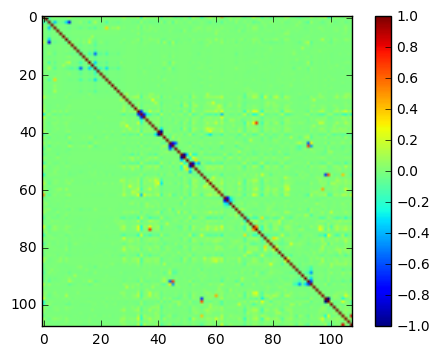

In [8]:
corr = qcdf.corr()
plt.imshow(corr)
plt.colorbar()
plt.show()

A few notes on this:

- I haven't provided p-values for these effects for a few reasons: 

    1. p-values are affected by both effect size and the amount of data that goes into the regression. Because there are different numbers of samples that have values recorded for each predictor, you can't look at a p-value to compare whether different terms have different importance.
    2. p-values from linear regression depend on the assumptions of the linear model, and those assumptions (principally homoscedasticity, and gaussian noise) are violated for most predictors here. The result is that the p-values that come out the back of the regression aren't meaningful. We could bootstrap p-values if we really wanted them.
    3. We've looked at dozens of potential predictors here. Some will appear to have significant p-values by chance. We could adjust these p-values for multiple comparisons, but given the above points it's not really worth it.
    
- We've looked at these predictors in isolation, we don't know what will happen yet when we combine them.